# Topsis on Pre-trained models for Text Summarization
### __Text Summarization__ refers to the process of condensing a large or lengthy piece of text into a shorter, concise version while retaining the most important information and meaning.
### It is an important application of Natural Language Processing (NLP) that helps users quickly understand the key points of a text without reading the entire content.
### In this notebook I will be applying TOPSIS to the models BART, T5, PEGASUS, and LED.
### I will also be calcuating BLEU and ROUGE scores for evaluation of the models.



### __Importing necessay libraries__

In [4]:
!pip install evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from evaluate import load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


### __Loading Evaluation Metrics__

In [6]:
!pip install rouge_score
bleu_metric = load("bleu")
rouge_metric = load("rouge")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b052dc6ad7dfc7baf2e1f1976e8938310eaa834f20a41def9e78f5e26319a29b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


### __Function to generate summaries for texts__

In [7]:
def generate_summaries(texts, model, tokenizer):
    summaries = []
    for text in texts:
        input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=512)
        summary_ids = model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0)
        summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary_text)
    return summaries

### __Text Snippet for evaluating the models__

In [8]:
text = "Climate change refers to long-term shifts in temperatures and weather patterns, mainly caused by human activities such as burning fossil fuels. The consequences include rising sea levels, melting ice caps, and more frequent extreme weather events. Mitigation and adaptation strategies are essential to address the impacts and transition to a sustainable future through renewable energy and conservation efforts."

### __Function to calculate evaluation metrics__

In [22]:
def calculate_metrics(references, summaries):
    metrics = {
        "BLEU": [],
        "ROUGE-1": [],
        "ROUGE-2": [],
        "ROUGE-L": [],
    }

    for ref, summary in zip(references, summaries):
        # BLEU score
        bleu_score = bleu_metric.compute(predictions=[summary], references=[[ref]])
        metrics["BLEU"].append(bleu_score["bleu"])

        # ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[summary], references=[ref])
        metrics["ROUGE-1"].append(rouge_scores["rouge1"])
        metrics["ROUGE-2"].append(rouge_scores["rouge2"])
        metrics["ROUGE-L"].append(rouge_scores["rougeL"])

    # mean scores
    avg_metrics = {key: np.mean(values) for key, values in metrics.items()}
    return avg_metrics

### __Loading Pre-trained Models__

In [10]:
models_info = [
    {"name": "facebook/bart-large-cnn", "label": "BART"},
    {"name": "t5-small", "label": "T5"},
    {"name": "google/pegasus-xsum", "label": "PEGASUS"},
    {"name": "allenai/led-base-16384", "label": "LED"}
]

### __Calculating the results__

In [24]:
results = []

for model_info in models_info:
    model = AutoModelForSeq2SeqLM.from_pretrained(model_info["name"])
    tokenizer = AutoTokenizer.from_pretrained(model_info["name"])

    # summary for the text
    summary = generate_summaries([text], model, tokenizer)[0]

    # Evaluate generated summaries
    metrics = calculate_metrics([text], [summary])

    results.append({
        "Model": model_info["label"],
        "Summary": summary,
        "BLEU Score": metrics["BLEU"],
        "ROUGE-1": metrics["ROUGE-1"],
        "ROUGE-2": metrics["ROUGE-2"],
        "ROUGE-L": metrics["ROUGE-L"]
    })

results_df = pd.DataFrame(results)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
print("Summaries generated by different models:")
print(results_df)
results_df.to_csv("summarization_results.csv", index=False)

Summaries generated by different models:
     Model                                            Summary  BLEU Score  \
0     BART  Climate change refers to long-term shifts in t...    0.788304   
1       T5  rising sea levels, melting ice caps, and more ...    0.504488   
2  PEGASUS  The United Nations Framework Convention on Cli...    0.000000   
3      LED  Climate change refers to long-term shifts in t...    1.000000   

    ROUGE-1   ROUGE-2   ROUGE-L  
0  0.907407  0.886792  0.907407  
1  0.731183  0.725275  0.731183  
2  0.254902  0.020000  0.176471  
3  1.000000  1.000000  1.000000  


### __Plotting metric comparisions__

<ipython-input-27-3fc1edf835fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


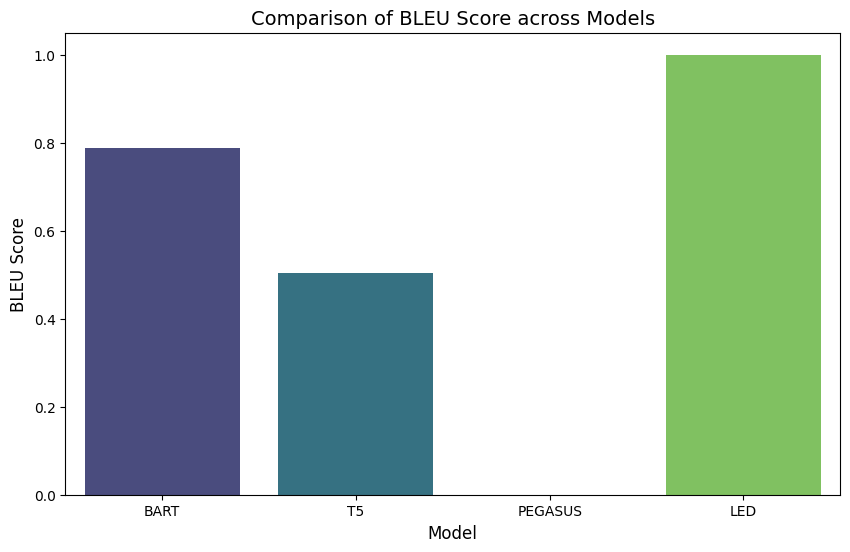

<ipython-input-27-3fc1edf835fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


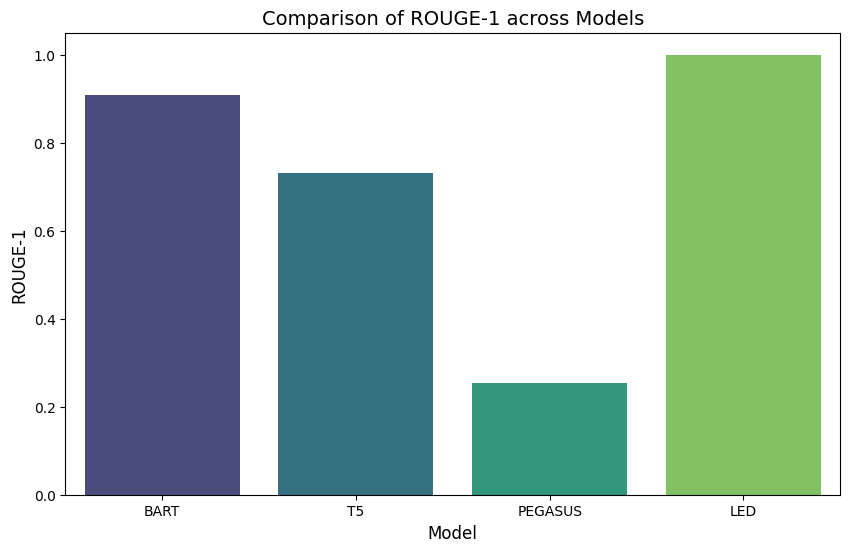

<ipython-input-27-3fc1edf835fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


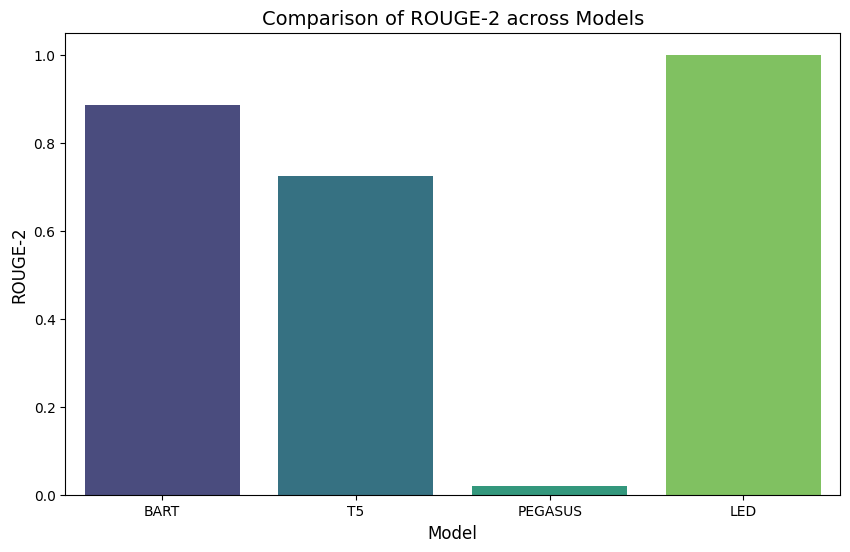

<ipython-input-27-3fc1edf835fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")


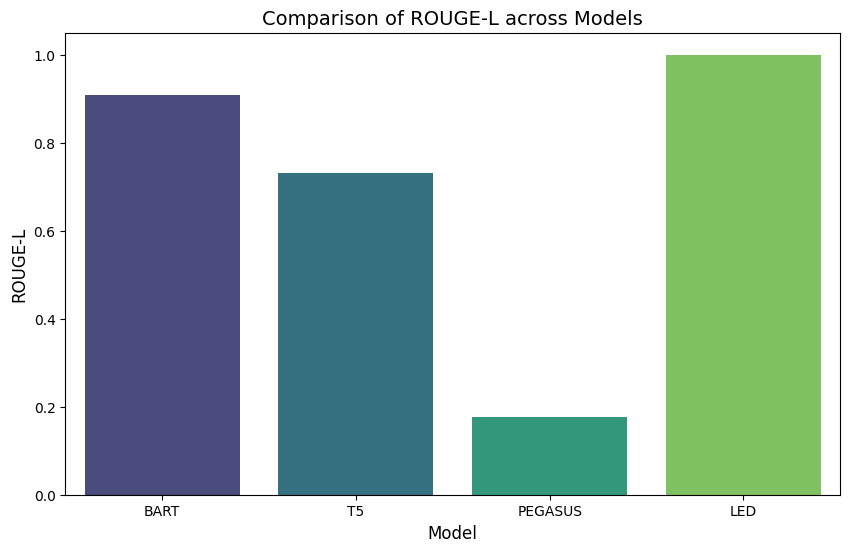

In [27]:
metrics = ["BLEU Score", "ROUGE-1", "ROUGE-2", "ROUGE-L",]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
    plt.title(f"Comparison of {metric} across Models", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.savefig(f"{metric.replace(' ', '_')}_comparison.png")
    plt.show()


### __Applying TOPSIS to the models__

In [28]:
weights = np.array([0.4, 0.4, -0.1, -0.1])
impacts = np.array([1, 1, -1, -1])

def topsis(data, weights, impacts):
    norm_data = data / np.sqrt((data**2).sum(axis=0))
    weighted_data = norm_data * weights
    ideal_best = np.max(weighted_data * (impacts == 1), axis=0) + np.min(weighted_data * (impacts == -1), axis=0)
    ideal_worst = np.min(weighted_data * (impacts == 1), axis=0) + np.max(weighted_data * (impacts == -1), axis=0)
    separation_best = np.sqrt(((weighted_data - ideal_best)**2).sum(axis=1))
    separation_worst = np.sqrt(((weighted_data - ideal_worst)**2).sum(axis=1))
    score = separation_worst / (separation_best + separation_worst)
    return score

data = results_df.iloc[:, 2:].values
results_df["TOPSIS Score"] = topsis(data, weights, impacts)
results_df["Rank"] = results_df["TOPSIS Score"].rank(ascending=False)


### __FINAL RESULTS__

In [32]:
TOPSIS_results = results_df.drop(columns=['Summary','BLEU Score','ROUGE-1','ROUGE-2','ROUGE-L'],axis=1)
TOPSIS_results=TOPSIS_results.sort_values('Rank')
TOPSIS_results.to_csv("TOPSIS_results.csv", index=False)
print("TOPSIS Evaluation Results:")
print(TOPSIS_results)

TOPSIS Evaluation Results:
     Model  TOPSIS Score  Rank
3      LED      1.000000   1.0
0     BART      0.814704   2.0
1       T5      0.552411   3.0
2  PEGASUS      0.000000   4.0


### __Visualizing the Results__

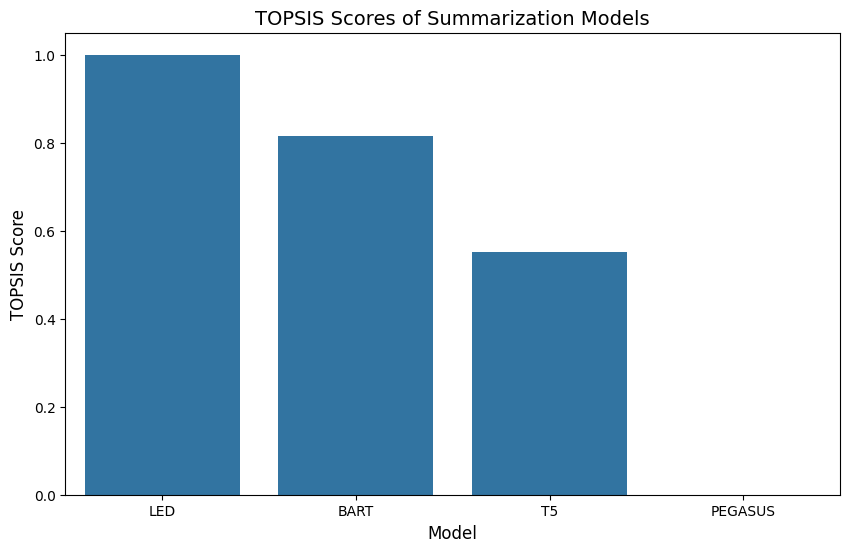

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="TOPSIS Score", data=TOPSIS_results)
plt.title("TOPSIS Scores of Summarization Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("TOPSIS Score", fontsize=12)
plt.savefig("TOPSIS_Scores.png")
plt.show()